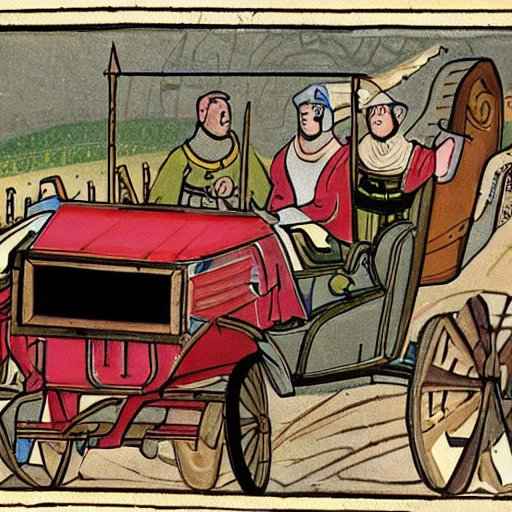

In [131]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [132]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [133]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [134]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [135]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  if app == False:
    print('\n!!!!')
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')
  if app == False:
    print('!!!!\n')  

In [136]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [137]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [138]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3523, grad_fn=<NegBackward0>)

In [139]:
# norm_logits = logits - logit_maxes
f'{norm_logits.shape=}',   f'{logits.shape=}', f'{logit_maxes.shape=}',

('norm_logits.shape=torch.Size([32, 27])',
 'logits.shape=torch.Size([32, 27])',
 'logit_maxes.shape=torch.Size([32, 1])')

In [140]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# -----------------
# YOUR CODE HERE :)
# -----------------

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n 
dprobs = probs **-1 * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# deriving this: counts_sum_inv = counts_sum**-1
dcounts_sum = dcounts_sum_inv * -counts_sum **-2
# dcounts is used in 2 branches
# 1) probs = counts * counts_sum_inv
dcounts = counts_sum_inv * dprobs
# 2) counts_sum = counts.sum(1, keepdims=True)
# counts.shape, counts_sum.shape
# (torch.Size([32, 27]), torch.Size([32, 1]))
# a11 a12 a13   b1 = a11 + a12 + a13
# a21 a22 a23   b2 = a21 + a22 + a23
# a31 a32 a33   b3 = a31 + a32 + a33
# remember addition is a router... 
dcounts += torch.ones_like(counts) * dcounts_sum
# the derivative of exp(x) is exp(x)
dnorm_logits = counts * dcounts
# the source: norm_logits = logits - logit_maxes
# there's broadcasting since logit_maxes is a column
# c11 c12 c13 = a11 a12 a13  b1
# c21 c22 c23 = a21 a22 a23 -b2
# c31 c32 c33 = a31 a32 a33  b3
# so e.g. c32 = a32 -b3
dlogits = dnorm_logits.clone() 
dlogit_maxes = (-dnorm_logits).sum(1,keepdims=True)
# dlogits has a second branch
# here: logit_maxes = logits.max(1, keepdim=True).values
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

# mind fuck! or remember @ transpose and go by dimensions (dh same size as h)
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
# see tanh derivative a = tanh(z) => da /dz = 1 - a2
dhpreact = (1 - h**2) * dh

# element wize multiplication is not the same as matrix multiply (@)
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact 
dbnbias = dhpreact.sum(0, keepdim=True)
# looking at: bnraw = bndiff * bnvar_inv
dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# looking at: bnvar_inv = (bnvar + 1e-5)**-0.5
dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
# looking at: bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
# when there's a sum in the forward pass:
# - this indicates (variable reuse) to squash a dimension using a sum
# - you'll get a broadcast (replication) in the backward pass
# when there's a broadcast in the backward:
# - this indicates variable reuse
# - you'll get a sum in the backward pass (variable reuse)
# toy example: sum and scale a 2x2 matrix into a 2x1
# a11 a12
# a21 a22
# ------>
# b1  b2 where
# b1 = 1/(n-1) * (a11 + a21)
# b2 = 1/(n-1) * (a21 + a22)
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2  
# looking at: bndiff = hprebn - bnmeani
dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)
# looking at: bnmeani = 1/n*hprebn.sum(0, keepdim=True)
dhprebn += 1.0/n * torch.ones_like(hprebn) * dbnmeani
# looking at: hprebn = embcat @ W1 + b1
# print(f'{hprebn.shape=}\n{embcat.shape=}\n{W1.shape=}\n{b1.shape=}\n\n')
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn 
db1 = dhprebn.sum(0)
# looking at: embcat = emb.view(emb.shape[0], -1) 
# print(f'{embcat.shape=}\n{emb.shape=}\n\n')
demb = dembcat.view(emb.shape)
# looking at: emb = C[Xb]
# print(f'{emb.shape=}\n{C.shape=}\n{Xb.shape=}\n')
# undo the indexing... 
dC = torch.zeros_like(C)
for k in range (Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

# ========================================
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

In [141]:
# backward faster

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # not exact

logits          | exact: False | approximate: True  | maxdiff: 6.28642737865448e-09


In [142]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmeani) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cvrpzhxquufhqvufkwmlpxgtvtykhkcasskejmzhutvfqpesvhc.
vgqeif.
rxmuqptceziivdpslhggphh.
mgfoinxqjqjtzs.
lilwa.
vvdbquwqztlogvjaryxixfqxekpiuuabwex.
fpxiq.
gtlffhysfxqvhpqg.
bvdjhksyjxpmqqovozewpcojq.
iyljkfrenqkpfsadluuo.
qoebstkowozhrxnpeaqpklhynrxpe.
xqivloqbplb.
bbda.
ipeqwuitjgbvmphzqxgpyctislqwvkrct.
zfuqnyjydpq.
kvweskgutkzambcejf.
vy.
qdyytoorowo.
ttbyhouokfxfcw.
zolphzcs.


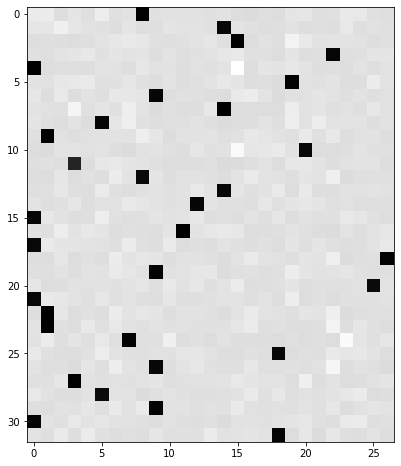

In [143]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')